<a href="https://colab.research.google.com/github/PatriciaLucas/Evapotranspiracao/blob/master/Gera_Serie_ETo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gera série temporal de Evapotranspiração de Referência

####Patrícia de Oliveira e Lucas
Referência: FAO 56 de 2006

In [0]:
import pandas as pd
from google.colab import files
import matplotlib as plt
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
import seaborn as sns

##Upload da base de dados do INMET já ajustada

Dados climáticos usados como entrada: 


*   Temperaturas (máxima, mínima e média) do ar em °C - Tmax, Tmin e Tmean
*   Umidade Relativa Média - RH
*   Insolação em Horas - I
*   Velocidade do vento em m/s - U2
*   Dia do ano - J



In [0]:
uploaded = files.upload()

In [0]:
dataset =  pd.read_csv('setelagoas_para calcular eto.csv',delimiter=';' )
data = np.asarray(dataset)
print('TAMANHO DA BASE DE DADOS: ',data.shape[0])
dataset.head()

TAMANHO DA BASE DE DADOS:  8400


,Data,Tmax,Tmin,I,Tmean,UR,V,J
0,1993-01-01,31.3,15.4,11.3,22.86,64.75,0.740445,1
1,1993-01-02,33.8,16.1,11.2,23.80,64.50,0.500000,2
2,1993-01-03,32.1,17.0,9.5,23.92,67.50,1.119698,3
3,1993-01-04,28.9,18.8,6.4,23.38,73.75,0.830743,4
4,1993-01-05,27.7,18.6,2.5,21.82,83.25,0.559849,5


##Constantes

Dados da estação meteorológica usados como entrada:

*   Latitude em radianos
*   Altitude em metros

Constante Solar é de  0.0820 $MJ\ m^{-2}\ {min}^{-1}$

Constante de Stefan Boltzmann é de 0.000000004903 $MJ\ m^{-2}\ {dia}^{-1}$


In [0]:
latitude_graus = -19.46 #--em graus
altitude = 732.00  #--em metros

latitude = math.pi/180 * latitude_graus #Converte a latitude de graus para radianos

#: Solar constant [ MJ m-2 min-1]
Gsc = 0.0820

# Stefan Boltzmann constant [MJ K-4 m-2 dia-1]
sigma = 0.000000004903

##Funções

###Pressão Atmosférica (P): 

Equação 7 (FAO 56):

$P = 101.3 \left(\frac{293-0.0065Z}{293}\right)^{5.26}$

onde: 

$P$ = Pressão atmosférica [$ kPa$]

$Z$ = altitude [$m$]

In [0]:
def Pressao_atm(altitude):
    """
    Pressão Atmosférica (P): Equação 7 (FAO 56)
    :parâmetro altitude: altitude acima do nível do mar [m]
    :return: pressão atmosférica [kPa]
    """
    tmp = (293.0 - (0.0065 * altitude)) / 293.0
    return math.pow(tmp, 5.26) * 101.3

### Constante Psicrométrica ($\gamma$)
Equação 8 (FAO 56, 2006)

$\gamma = 0.000663 P $

onde: 

$\gamma$ = constante psicrométrica [$kPa \ ºC^{-1}$]

$P$ = pressão atmosférica [$kPa$]

In [0]:
def psicrometrica(pressao_atm):
    """
    Constante Psicrométrica ( γ ): Equação 8 (FAO 56, 2006)
    :parâmetro pressao_atm: pressão atmosférica [kPa]. Estimada pela função pressao_atm().
    :return: Constante psicrométrica [kPa C-1].
    """
    return 0.000665 * pressao_atm

### Pressão de vapor saturado médio ($e_s$) à temperatura do ar
Equação 11 (FAO 56, 2006)

$e_s =  0.6108^{\frac{17.27 T}{T+237.3}}$

onde:

$e_s$ = pressão de vapor saturado médio [$kPa$]

$T$ = temperatura [$ºC$]

OBS: Calcular para a temperatura máxima, para a mínima e tirar a média entre as duas (Equação 12).

In [0]:
def Es(t):
    """
    Pressão de vapor saturado médio ( es ) à temperatura do ar: Equação 11 (FAO 56)
    :parâmetro t: temperatura [C]
    :return: pressão de vapor saturado [kPa]
    """
    return 0.6108 * math.exp((17.27 * t) / (t + 237.3))

In [0]:
def Es_medio(tmin, tmax):
    """
    :parâmetro tmin: temperatura mínima [C]
    :parâmetro tmax: temperatura máxima [C]
    :return: pressão média de vapor saturado [kPa]
    """
    return (Es(tmin) + Es(tmax)) / 2.0

###Declividade da curva de pressão do valor de saturação ($\Delta$)
Equação 13 (FAO 56, 2006)

$\Delta = \frac{4098 \left[0.6108^{\frac{17.27T}{T+237.3}}\right]}{(T+237.3)^2}$

onde:

$\Delta$ = declividade da curva de pressão do valor de saturação [$kPa \ ºC^{-1}$]

$T$ = temperatura média [$ºC$]

In [0]:
def Delta(tmedia):
    """
    Declividade da curva de pressão do valor de saturação ( Δ ): Equação 13 (FAO 56)
    :parâmetro t: Temperatura média [C].
    :return: declividade da curva de pressão do valor de saturação [kPa C-1]
    """
    tmp = 4098 * (0.6108 * math.exp((17.27 * tmedia) / (tmedia + 237.3)))
    return tmp / math.pow((tmedia + 237.3), 2)

###Pressão de vapor atual ($e_a$) usando umidade relativa média ($RH$)


Equação 19 (FAO 56, 2006)

$e_a = \frac{RH}{100}e_s$

onde: 

$e_a$ = pressão de vapor atual  [$kPa$]

$RH$ = é a umidade relativa média [%]


---

OBS: em caso de ausência de RH, será usada a Equação 48 (FAO 56, 2006)


$e_a = 0.611^\left(\frac{17.27 T_{min}}{T_{min} + 237.3}\right)$

$e_a$ = pressão de vapor atual  [$kPa$]

$T_{min}$ = temperatura mínima  [$ºC$]


In [0]:
def Ea(tmin, tmax, RH):
    """
    Pressão de vapor atual ( ea ) usando umidade relativa média ( RH ): Equação 19 (FAO 56)
    OBS: em caso de ausência de RH, será usada a Equação 48 (FAO 56)
    :parâmetro tmin: temperatura mínima [C]
    :parâmetro tmax: temperatura máxima [C]
    :parâmetro RH: umidade relativa média [%]
    :return: pressão de vapor atual [kPa]
    """
    if np.isnan(RH):
      ea = 0.611 * math.exp((17.27 * tmin) / (tmin + 237.3))
    else:
      ea = (RH * Es_medio(tmax,tmin))/ 100.0
    return ea


###Radiação extraterrestre para períodos diários ($R_a$)
Equação 21 (FAO 56, 2006)

$R_a = \frac{24.6}{\pi} G_{sc} d_r [\omega_s sen(\phi) sen(\delta) + cos(\phi) cos(\delta) sen(\omega_s)]$

onde: 

$R_a$ = radiação extraterrestre para períodos diários  [$MJ \ m^{-2} \ dia^{-1}$]

$G_{sc}$ = constante solar  [$MJ \ m^{-2} \ min^{-1}$]

$d_r$ = inverso da distância relativa da terra-sol (Equação 23)

$\delta$ = declinação do sol [rad] (Equação 24)

$\omega_s$ = ângulo horário do pôr-do-sol  [rad] (Equação 25)

$\phi$ = latitude [rad]

In [0]:
def Ra(latitude, declinacao_sol, omega, dr):
    """
    Radiação extraterrestre para períodos diários ( Ra ): Equação 21 (FAO 56)
    :parâmetro latitude: latitude [rad]
    :parâmetro declinacao_sol: declinação do sol [rad]. Calculada pela função declinacao_sol().
    :parâmetro omega: ângulo horário pôr-do-sol [rad]. Calculado pela função omega().
    :parâmetro dr: inverso da distância relativa da terra-sol. Calculada pela função dr().
    :return: Radiação extraterrestre para períodos diários [MJ m-2 day-1]
    """

    tmp1 = (24.0 * 60.0) / math.pi
    tmp2 = omega * math.sin(latitude) * math.sin(declinacao_sol)
    tmp3 = math.cos(latitude) * math.cos(declinacao_sol) * math.sin(omega)
    return tmp1 * Gsc * dr * (tmp2 + tmp3)

In [0]:
def Declinacao_sol(J):
    """
    :parâmetro J: dia do ano, inteiro de 1 a 365 ou 366.
    :return: declinação solar [rad]
    """
    return float(0.409) * math.sin(((float(2.0) * math.pi / float(365.0)) * J - float(1.39)))

In [0]:
def Omega(latitude, declinacao_sol):
    """
    :parâmetro latitude: latitude [rad].
    :parâmetro declinacao_sol: declinação solar [rad]. Calculada pela função declinacao_sol().
    :return: ângulo horário pôr-do-sol [rad].
    """

    cos_sha = -math.tan(latitude) * math.tan(declinacao_sol)
    return math.acos(min(max(float(cos_sha), float(-1.0)), float(1.0)))

In [0]:
def Dr(J):
    """
    :parâmetro J: dia do ano, inteiro de 1 a 365 ou 366.
    :return: inverso da distância relativa da terra-sol.
    """
    return 1 + (0.033 * math.cos((2.0 * math.pi / 365.0) * J))

###Duração máxima de insolação no dia (N)
Equação 34 (FAO 56, 2006)

$N = \frac{24}{\pi} \omega_s$

onde:

$N$ = duração máxima de insolação no dia [h]

$\omega_s$ =  ângulo horário do pôr-do-sol [rad]

In [0]:
def N_insolacao(omega):
    """
    Duração máxima de insolação no dia (N): Equação 34 (FAO 56)
    :parâmetro omega: ângulo horário do pôr-do-sol [rad]. Calculado pela função omega()
    :return: duração máxima de insolação no dia [h].
    """
    return (24.0 / math.pi) * omega

###Radiação Solar ($R_s$)
Equação 35 (FAO 56, 2006)

$R_s = (a_s + b_s \frac{n}{N}) R_a$

onde: 

$R_s$ = radiação solar [$MJ \ m^{-2} \ dia^{-1}$]

$n$ = insolação (duração real da luz do dia) [$h$]

$N$ = duração máxima de insolação no dia [$h$]

$R_a$ = radiação extraterrestre [$MJ \ m^{-2} \ dia^{-1}$]

$a_s$ e $b_s$  são 0.25 e 0.5 respectivamente. Esses valores são recomendados quando a radiação solar não está disponível. 


---

Equação 50 (FAO 56, 2006)

$R_s = k_{Rs} \sqrt{T_{max} - T_{min}} \ R_a$

onde:

$R_s$ = radiação solar [$MJ \ m^{-2} \ dia^{-1}$]

$T_{max}$ = temperatura máxima  [$ºC$]

$T_{min}$ = temperatura mínima  [$ºC$]

$k_{Rs}$ = coeficiente de ajuste (0,16 .. 0,19) [$°C^{-0,5}$].  Para localidades interiores, onde a massa de terra domina, e as massas de ar não são influenciadas por uma corpo grande água, $k_{Rs} ≈ 0,16$. 

In [0]:
def Rs(N, n, ra, tmax, tmin):
    """
    Radiação Solar ( Rs ): Equação 35 (FAO 56)
    OBS: em caso de ausência de n, será usada a Equação 50 (FAO 56)
    :parâmetro N: duração máxima de insolação no dia [h]. Pode ser calculada pela função N.
    :parâmetro n: Insolação [h].
    :parâmetro Ra: extraterrestrial radiation [MJ m-2 day-1]. Calculada pela função Ra.
    :return: radiação solar [MJ m-2 day-1]
    """
    if np.isnan(n):
      rs = 0.16 * np.sqrt(tmax - tmin) * ra
    else:
      rs = (0.5 * n / N + 0.25) * ra
    return rs

###Radiação Solar de Céu Claro ($R_{so}$) para valores não calibrados de $a_s$ e $b_s$

Equação 37 (FAO 56, 2006)

$R_{so} = (0.75 + 2 \cdot 10^{-5} Z) R_a$

onde:

$R_{so}$ = radiação solar de céu claro [$MJ \ m^{-2} \ dia^{-1}$]

$Z$ = altitude acima do nível do mar [m]

$R_a$ = radiação extraterrestre [$MJ \ m^{-2} \ dia^{-1}$]

In [0]:
def Rso(altitude, ra):
    """
    Radiação Solar de Céu Claro ( Rso ) para valores não calibrados de as e bs: Equação 37 (FAO 56)
    :parâmetro altitude: altitude acima do nível do mar [m]
    :parâmetro ra: extraterrestrial radiation [MJ m-2 day-1]. Calculada pela função Ra.
    :return: radiação solar de céu claro [MJ m-2 day-1]
    """
    return (0.00002 * altitude + 0.75) * ra

###Radiação de onda curta líquida ou solar líquida ($R_{ns}$)
Equação 38 (FAO 56, 2006)

$R_{ns} = (1-\alpha) R_s$

onde: 

$R_{ns}$ = radiação de onda curta líquida [$MJ \ m^{-2} \ dia^{-1}$]

$R_s$ = radiação solar [$MJ \ m^{-2} \ dia^{-1}$]

$\alpha$ = albedo ou coeficiente de reflexão do dossel, é de 0.23 para a cultura de referência grama hipotética.

In [0]:
def Rns(rs, albedo=0.23):
    """
    Radiação de onda curta líquida ou solar líquida ( Rns ): Equação 38 (FAO 56)
    :parâmetro rs: radiação solar [MJ m-2 day-1]. Calculada pela função Rs().
    :parâmetro albedo: coeficiente de reflexão do dossel,  é de 0.23 para a cultura de referência grama hipotética.
    :return: radiação de onda curta líquida [MJ m-2 day-1].
    """
    return (1 - albedo) * rs

###Radiação de onda longa líquida ($R_{nl}$)
Equação 39 (FAO 56, 2006)

$R_{nl} = \sigma \left[\frac{T_{max,k^4}+T_{min,k^4}}{2}\right](0.34 - 0.14 \sqrt{e_a})(1.35 \frac{R_s}{R_{so}} - 0.35)$

onde: 

$R_{nl}$ = radiação de onda longa líquida [$MJ \ m^{-2} \ dia^{-1}$]

$\sigma$ = constante de Stefan-Boltzmann [$4.903 \cdot 10^{-9} MJ K^{-4} m^{-2} dia^{-1}$]

$T_{max,k^{-4}}$ = Temperatura absoluta máxima durante 24h em Kelvin

$T_{min,k^{-4}}$ = Temperatura absoluta mínima durante 24h em Kelvin

$e_a$ = pressão de vapor atual  [$kPa$]

$\frac{R_s}{R_{so}}$ = Radiação relativa de onda curta (deve ser < = 1.0)

In [0]:
def Rnl(tmin, tmax, rs, rso, ea):
    """
    Radiação de onda longa líquida ( Rnl ): Equação 39 (FAO 56)
    :parâmetro tmin: Temperatura mínima absoluta [K]
    :parâmetro tmax: Temperatura máxima absoluta [K]
    :parâmetro Rs: radiação solar [MJ m-2 day-1]. Calculada pela função Rs().
    :parâmetro Rso: radiação solar de céu claro [MJ m-2 day-1]. Calculada pela função Rso().
    :parâmetro ea: pressão de vapor atual [kPa]. Calculada pela função Ea().
    :return:  radiação de onda longa líquida [MJ m-2 day-1]
    """
    tmax_k = tmax + 273.16 #----Converte a temperatura de °C para °K
    tmin_k = tmin + 273.16 #----Converte a temperatura de °C para °K
    
    tmp1 = (sigma * ((math.pow(tmax_k, 4) + math.pow(tmin_k, 4)) / 2))
    tmp2 = (0.34 - (0.14 * math.sqrt(ea)))
    tmp3 = 1.35 * (rs / rso) - 0.35
    return tmp1 * tmp2 * tmp3

###Radiação líquida ($R_n$)
Equação 40 (FAO 56, 2006)

$R_n = R_{ns} - R_{nl}$

In [0]:
def Rn(rns, rnl):
    """
    Radiação líquida ( Rn ): Equação 40 (FAO 56)
    :parâmetro rns: radiação de onda curta líquida [MJ m-2 day-1]. Calculada pela função Rns().
    :parâmetro rnl: radiação de onda longa líquida [MJ m-2 day-1]. Calculada pela função Rnl().
    :return: radiação líquida [MJ m-2 day-1].
    """
    return rns - rnl

###Fluxo de calor do solo (G) para o período de 1 dia ou 10 dias

Equação 42 (FAO 56, 2006)

G = 0

In [0]:
G = 0

###Evapotranspiração de referência (ETo)
Equação 6 (FAO 56, 2006)

>>>$ET_o = \frac{0.408 \Delta (R_n - G) + \gamma \frac{900}{T+273}u_2 (e_s - e_a)}{\Delta + \gamma (1+0.34 u_2)}$





onde:

$ET_o$ = Evapotranspiração de referência [$mm \ dia^{-1}$]

$R_n$ = Radiação líquida à superfície de cultura [$MJ \ m^{-2} \ dia^{-1}$]

$G$ = Densidade do fluxo de calor do solo [$MJ \ m^{-2} \ dia^{-1}$]

$T$ = Temperatura média diária a 2m de altura [ºC]

 $u_2$ = Velocidade do vento a 2m de altura [$m/s^{-1}$]
 
 $e_s$ = Pressão do vapor de saturação [$kPa$]
 
 $e_a$ = Pressão do vapor atual  [$kPa$]
 
 $(e_s - e_a)$ = Déficit de pressão do vapor de saturação  [$kPa$]
 
 $\Delta$ = Declividade da curva de pressão do vapor  [$kPa \ ºC^{-1}$]
 
 $\gamma$ = Constante psicrométrica [$kPa \ ºC^{-1}$]



In [0]:
def fao56_penman_monteith(rn, t, u2, es, ea, delta, gamma, G):
    """
    Evapotranspiração de referência (ETo): Equação 6 (FAO 56)
    :parâmetro rn: Radiação líquida à superfície de cultura [MJ m-2 day-1]. Calculada pela função Rn().
    :parâmetro t: Temperatura média diária a 2m de altura [K].
    :parâmetro u2:  Velocidade do vento a 2m de altura [m s-1].
    :parâmetro es: Pressão do vapor de saturação [kPa]. Calculada pela função Es().
    :parâmetro ea: Pressão do vapor atual  [kPa]. Calculada pela função Ea().
    :parâmetro delta: Declividade da curva de pressão do vapor [kPa degC-1]. Calculada pela função Delta().
    :parâmetro gamma: Constante psicrométrica [kPa deg C]. Calculada pela função psicrométrica().
    :parâmetro G: Densidade do fluxo de calor do solo  [MJ m-2 day-1].
    :return: Evapotranspiração de referência (ETo) [mm day-1].
    """
    a1 = (0.408 * (rn - G) * delta) + ((900 / (t + 273)) * u2 * gamma * (es - ea))
    a2 =  a1 / (delta + (gamma * (1 + 0.34 * u2)))
    return a2

###Gera a série temporal de $ET_o$

In [0]:
def gera_serie(data):
  eto = []
  for i in range(len(data)):
    es = Es_medio(data[i,2],data[i,1]) #------------> Pressão do vapor de saturação
    ea = Ea(data[i,2],data[i,1],data[i,5]) #--------> Pressão do vapor atual
    delta = Delta(data[i,4]) #----------------------> Declividade da curva de pressão do vapor
    pressao_atm = Pressao_atm(altitude) #-----------> Pressão atmosférica
    gamma = psicrometrica(pressao_atm) #------------> Constante
    declinacao_sol = Declinacao_sol(data[i,7]) #----> Declinação solar
    omega = Omega(latitude, declinacao_sol) #-------> Ângulo horário pôr-do-sol
    dr = Dr(data[i,7]) #----------------------------> Inverso da distância relativa da terra-sol
    ra = Ra(latitude, declinacao_sol, omega, dr) #--> Radiação extraterrestre para períodos diários
    N = N_insolacao(omega) #------------------------> Duração máxima de insolação no dia
    rs = Rs(N, data[i,3], ra, data[i,1], data[i,2]) #---------------------> Radiação solar
    rso = Rso(altitude, ra) #-----------------------> Radiação solar de céu claro
    rns = Rns(rs, albedo=0.23) #--------------------> Radiação de onda curta líquida
    rnl = Rnl(data[i,2],data[i,1], rs, rso, ea) #---> Radiação de onda longa líquida
    rn = Rn(rns,rnl) #------------------------------> Radiação líquida
    eto.append(fao56_penman_monteith(rn, data[i,4], data[i,6], es, ea, delta, gamma, G)) #---> Evapotranspiração
  
  return eto

In [0]:
eto = gera_serie(data)

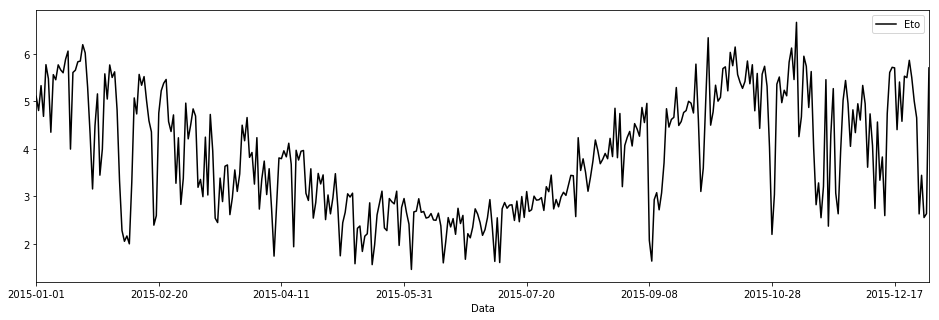

In [0]:
df = pd.DataFrame(eto,columns=['Eto'])
df.insert(0,'Data', dataset.loc[:,'Data'])
df.set_index('Data', inplace=True)
#df.index = df.index.to_datetime('"%y-%m-%d"')
df['2015-01-01':].plot(figsize=(16,5), color='k')

##Download da série temporal de Evapotranspiração de referência

In [0]:
eto_csv = df.to_csv('eto_csv',index=True)
files.download('eto_csv') 